Links:
* [h3 edges](https://h3geo.org/docs/highlights/aggregation)


## Initial setup

In [115]:
from shapely.geometry import Point, Polygon, GeometryCollection, shape
from datetime import datetime
import h3.api.numpy_int as h3
import pandas as pd
import geopandas as gpd
import numpy as np
import folium
import branca
import geojson
from route3_road_client import Server

server = Server(hostport="127.0.0.1:7088")

graph_h3_resolution = server.graph_info().h3_resolution

def dataframe_to_geodataframe(df: pd.DataFrame, column_name: str = "h3index") -> gpd.GeoDataFrame:
    return gpd.GeoDataFrame(df,
                            geometry=[Polygon(h3.h3_to_geo_boundary(h, geo_json=True)) for h in
                                      np.nditer(df[column_name].to_numpy())],
                            crs=4326)


# test POIs - fast food shops. Can be created using the top-level justfile
poi_df = gpd.read_file("../../data/hospital.geojson")
del poi_df['@id']
print(f"Using {len(poi_df)} POI locations")

# only use points
poi_df["geometry"] = poi_df.geometry.centroid

# create the h3indexes for the geometries to have them available for the
# attribution in maps later
poi_df["h3index"] = poi_df.geometry.map(lambda geom: h3.geo_to_h3(geom.y, geom.x, graph_h3_resolution))

poi_df

Using 5081 POI locations


/tmp/ipykernel_97021/267155355.py:29: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  poi_df["geometry"] = poi_df.geometry.centroid


name   amenity  \
0                               Kreiskrankenhaus Torgau  hospital   
1                             Haupteingang Moltkestraße      None   
2                                Diakonissenkrankenhaus  hospital   
3                       Stiftungskrankenhaus Nördlingen  hospital   
4                                   Medizinische Klinik  hospital   
...                                                 ...       ...   
5076                          Universitätsklinikum Jena  hospital   
5077  Universitätsklinikum Jena - Standort Philosoph...  hospital   
5078  Universitätsklinikum Jena - Standort Erfurter ...  hospital   
5079                   Knappschaftskrankenhaus Sulzbach  hospital   
5080                              Asklepios Stadtklinik  hospital   

                       geometry             h3index  
0     POINT (12.98463 51.56156)  622043784436940799  
1      POINT (8.37468 49.01561)  622051260145106943  
2      POINT (8.40941 48.97196)  622051256262852607  
3     POINT (10.49856 48.83709)  622053877832351743  
4     POINT (11.56182 48.13225)  622051814475235327  
...                         ...                 ...  
5076  POINT (11.62072 50.88567)  622043917238271999  
5077  POINT (11.58151 50.93265)  622054004634353663  
5078  POINT (11.56450 50.93451)  622054004623278079  
5079   POINT (7.05477 49.29778)  622053337300795391  
5080  POINT (11.55075 47.75630)  622051496593391615  

[5081 rows x 4 columns]

## Create a disturbance which hinders traffic

You can use [geojson.io](http://geojson.io) to draw a featurecollection and paste it into the string bellow.

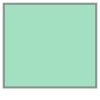

In [116]:
disturbance_geojson_string = """
{
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              10.87320327758789,
              47.91300548190604
            ],
            [
              10.876636505126953,
              47.91300548190604
            ],
            [
              10.876636505126953,
              47.91611193960253
            ],
            [
              10.87320327758789,
              47.91611193960253
            ],
            [
              10.87320327758789,
              47.91300548190604
            ]
          ]
        ]
      }
    }
  ]
}
"""


disturbance = GeometryCollection([shape(feature["geometry"]).buffer(0) for feature in geojson.loads(disturbance_geojson_string)["features"]])
disturbance

## Route and Analyze

In [118]:
t_start = datetime.now()
dopm_id, dopm_df = server.analyze_disturbance_of_population_movement(
    disturbance, 
    35000.0, 
    poi_df.geometry, 
    num_destinations_to_reach=2,
    num_gap_cells_to_graph=3,
)
print(f"took {datetime.now() - t_start}")
print(f"id: {dopm_id}")

geo_df = dataframe_to_geodataframe(dopm_df, column_name="h3index_origin")
geo_df["cost_increase"] = geo_df["avg_cost_with_disturbance"] - geo_df["avg_cost_without_disturbance"]
geo_df

took 0:00:10.779917
id: c04656a8-7dc2-4531-b77c-8b5e0bdc0f6f


h3index_origin  preferred_dest_h3index_without_disturbance  \
0     622051487042076671                                6.220515e+17   
1     622051492237836287                                6.220517e+17   
2     622051486911823871                                6.220515e+17   
3     622051486553178111                                6.220515e+17   
4     622051488274153471                                6.220515e+17   
...                  ...                                         ...   
6415  622051492237606911                                6.220517e+17   
6416  622051492839194623                                6.220517e+17   
6417  622051487017205759                                6.220515e+17   
6418  622051490421211135                                6.220515e+17   
6419  622051490413281279                                6.220515e+17   

      preferred_dest_h3index_with_disturbance  population_origin  \
0                                6.220515e+17           9.400260   
1                                6.220517e+17           4.910148   
2                                6.220515e+17           2.106676   
3                                6.220515e+17           7.002126   
4                                6.220515e+17           1.775257   
...                                       ...                ...   
6415                             6.220517e+17          18.413055   
6416                             6.220517e+17          55.680443   
6417                             6.220515e+17         110.688927   
6418                             6.220515e+17          91.010895   
6419                             6.220515e+17           4.919508   

      num_reached_without_disturbance  num_reached_with_disturbance  \
0                                   2                             2   
1                                   2                             2   
2                                   2                             2   
3                                   2                             2   
4                                   2                             2   
...                               ...                           ...   
6415                                2                             2   
6416                                2                             2   
6417                                2                             2   
6418                                2                             2   
6419                                2                             2   

      avg_cost_without_disturbance  avg_cost_with_disturbance  \
0                            475.5                      505.0   
1                            396.0                      396.0   
2                            542.5                      542.5   
3                            608.5                      608.5   
4                            868.0                      868.0   
...                            ...                        ...   
6415                         412.0                      412.0   
6416                         229.0                      229.0   
6417                         483.5                      483.5   
6418                         457.0                      457.0   
6419                         489.0                      489.0   

                                               geometry  cost_increase  
0     POLYGON ((10.88022 47.83286, 10.87995 47.83222...           29.5  
1     POLYGON ((10.84360 47.94963, 10.84333 47.94898...            0.0  
2     POLYGON ((10.78486 47.83765, 10.78459 47.83700...            0.0  
3     POLYGON ((10.82725 47.86779, 10.82698 47.86714...            0.0  
4     POLYGON ((11.00088 47.94765, 11.00061 47.94701...            0.0  
...                                                 ...            ...  
6415  POLYGON ((10.84063 47.94901, 10.84036 47.94836...            0.0  
6416  POLYGON ((10.82483 48.01874, 10.82456 48.01810...            0.0  
6417  POLYGON ((10.87570 47.80064, 10

... now map it ...

In [121]:
map_content_disolved = geo_df.dissolve().geometry[0].convex_hull
map_center = map_content_disolved.centroid

m = folium.Map(location=[map_center.y, map_center.x], zoom_start=11, tiles='OpenStreetMap', 
               #crs="EPSG4326"
              )

poi_df_subset = poi_df.loc[poi_df.geometry.within(map_content_disolved.buffer(0.8))]

folium.GeoJson(
    # use only a subset of the POIs to speed up rendering
    poi_df_subset,
    style_function=lambda x: {
        'fillColor': "#c00", 
        'color' : '#800',
        'weight' : 1,
        'fillOpacity' : 0.3,
    },
    tooltip=folium.features.GeoJsonTooltip([
        "name",
        "h3index",
    ])
    ).add_to(m) 

folium.GeoJson(
    disturbance,
    style_function=lambda x: {
        'fillColor': "#c00", 
        'color' : '#800',
        'weight' : 1,
        'fillOpacity' : 0.3,
    },
    ).add_to(m)    
    

colorscale_cell_worsen = branca.colormap.LinearColormap(
    ((1.,1.,1.), (0.0,0.0,1.0)), 
    vmin=0.0, 
    vmax=geo_df['cost_increase'].max()
) 
   
def style_cell(feature):
    cost_inc = feature['properties']['cost_increase'] 
    if cost_inc is None:
        fill = '#f00' # no route found
    else: 
        fill = colorscale_cell_worsen(cost_inc)
    return {
        'fillColor': fill, 
        'color' : '#555',
        'weight' : 1,
        'fillOpacity' : 0.8,
    }

folium.GeoJson(
    geo_df,
    style_function=style_cell,
    tooltip=folium.features.GeoJsonTooltip([
        "h3index_origin",
        "avg_cost_without_disturbance",
        "avg_cost_with_disturbance",
        "cost_increase",
        "population_origin", 
        "preferred_dest_h3index_without_disturbance", 
        "preferred_dest_h3index_with_disturbance",
        "num_reached_without_disturbance",
        "num_reached_with_disturbance",
    ])
    ).add_to(m)    
    
m

In [120]:
some_cells = list(geo_df.sort_values(["cost_increase"], ascending=False).h3index_origin)[:2]

route_gdf = server.get_disturbance_of_population_movement_routes(dopm_id, some_cells)
len(route_gdf)
route_gdf

geometry      h3index_origin  \
0  LINESTRING (10.87566 47.91213, 10.87611 47.911...  622051487238520831   
1  LINESTRING (10.87566 47.91213, 10.87611 47.911...  622051487238520831   
2  LINESTRING (10.87566 47.91213, 10.87611 47.911...  622051487238520831   
3  LINESTRING (10.87566 47.91213, 10.87522 47.913...  622051487238520831   
4  LINESTRING (10.87871 47.90864, 10.87915 47.907...  622051487237341183   
5  LINESTRING (10.87871 47.90864, 10.87915 47.907...  622051487237341183   
6  LINESTRING (10.87871 47.90864, 10.87915 47.907...  622051487237341183   
7  LINESTRING (10.87871 47.90864, 10.87700 47.908...  622051487237341183   

   h3index_destination   cost  with_disturbance  
0   622051486983454719  308.0                 1  
1   622051739338506239  817.0                 1  
2   622051486983454719  308.0                 0  
3   622051739338080255  451.0                 0  
4   622051486983454719  296.0                 1  
5   622051739338506239  805.0                 1  
6   622051486983454719  296.0                 0  
7   622051739338080255  463.0                 0

In [ ]:
def style_route(feature):
    if feature['properties']['with_disturbance']:
        color = '#f00'
    else: 
        color = "#0f0"
    return { 
        'color' : color,
        'weight' : 2,
    }

folium.GeoJson(
    route_gdf, #[route_gdf['with_disturbance'] == 0],
    style_function=style_route,
    tooltip=folium.features.GeoJsonTooltip([
        "h3index_origin",
        "h3index_destination",
        "cost",
    ])
    ).add_to(m)    
    
m

## Retrieve results again using the ID

In [ ]:
dopm_id, dopm_df = server.get_disturbance_of_population_movement(dopm_id)
dopm_df